In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU, Softmax
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng

from gmm import GMM
# circuit-sim
# import subcircuit as sc
# import PySpice.Logging.Logging as Logging
# logger = Logging.setup_logging()
# from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
# from PySpice.Unit import *
# from PySpice.Spice.NgSpice.Shared import NgSpiceShared


| Type | Value                          | Type | Value                              |
|------|--------------------------------|------|------------------------------------|
| Node | capacitance value              | Path | input transition time              |
|      | num of input nodes             |      | drive strength of drive cell       |
|      | total input cap                |      | functionality  of drive cell       |
|      | total output cap               |      | drive strength of load cell        |
|      | number of connected resistance |      | functionality of load cell         |
|      | total input resistance         |      | effective capacitance of load cell |
|      | total output resistance        |      | wire path Elmore delay             |
|      | ~~Elmore downstream capacitance~~  |      | wire path D2M delay                |
|      | ~~Elmore stage delay~~             |      |                                    |

Adj Matrix:  [[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]
Paths:  [[0, 1, 2, 3]]
Path Features:  tensor([[2., 2., 1., 5., 1., 5., 4., 1.]])
Adj Matrix with Edge Weights:  [[0 1 0 0]
 [1 0 2 0]
 [0 2 0 5]
 [0 0 5 0]]
Resistance:  [(0, 1, 1), (1, 2, 2), (2, 3, 5)]


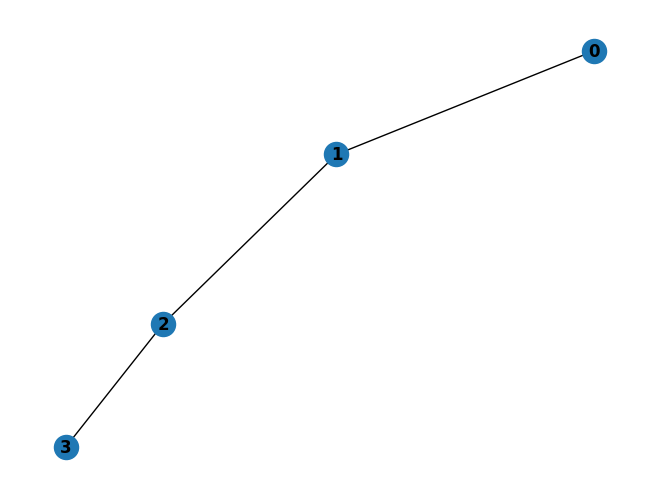

In [7]:
import networkx as nx
import random

''' Sample Graph '''
# graph configuration
num_nodes = 4
num_edges = 3
num_path_features = 8
num_node_features = 9

# set seed for random number generator
random.seed(42)

# create a linear graph with 4 nodes and 3 edges
G = nx.path_graph(4)

# assign random values to node attributes
for i in range(num_nodes):
    G.nodes[i]['capacitance'] = random.randint(1, 5)
    if i == 0:
        G.nodes[i]['num_input_nodes'] = 0
    else:
        G.nodes[i]['num_input_nodes'] = 1

    G.nodes[i]['input_cap'] = 1
    G.nodes[i]['output_cap'] = 1

    if i == num_nodes - 1:
        G.nodes[i]['connected_resistance'] = 0
    else:
        G.nodes[i]['connected_resistance'] = 1

    G.nodes[i]['input_resistance'] = 1
    G.nodes[i]['output_resistance'] = 1
    G.nodes[i]['elmore_cap'] = 1

    if i == 0:
        G.nodes[i]['elmore_delay'] = 0
    else:
        G.nodes[i]['elmore_delay'] = 1


# get the adjacency matrix
M_adj = nx.adjacency_matrix(G)
print("Adj Matrix: ", M_adj.A)

# extract all paths
paths = nx.all_simple_paths(G, source=0, target=3)
list_of_paths = list(paths)
print("Paths: ", list_of_paths)

# create a matrix of [num_paths, num_path_features]
M_path = torch.zeros(len(list_of_paths), num_path_features)

# assign random value to the paths
for i in range(len(list_of_paths)):
    for j in range(num_path_features):
        M_path[i,j] = random.randint(1, 5)

print("Path Features: ", M_path)

# assign random value to the edges
for i in range(num_nodes):
    for j in range(num_nodes):
        if M_adj.A[i,j] == 1:
            G.edges[i,j]['weight'] = random.randint(1, 5)

# add edge weights to adjacency matrix
for i in range(num_nodes):
    for j in range(num_nodes):
        if M_adj.A[i,j] == 1:
            M_adj.A[i,j] = G.edges[i,j]['weight']

print("Adj Matrix with Edge Weights: ", nx.adjacency_matrix(G).A)

print("Resistance: ", G.edges.data('weight'))

# plot the graph with edge weights
nx.draw(G, with_labels=True, font_weight='bold')



$$x_i^{l_1} = ReLU(W_1^{l_1}x_i^{l_1-1}+W_2^{l_1}a_{iu}\sum_{u\in \mathcal{N}(v_i)}x_u^{l_1-1})$$

In [3]:
from torch_geometric.utils import to_dense_adj
# torch random seed
torch.manual_seed(42)

class L1_GNNModule(nn.Module):
    """
    Modified GraphSAGE module with weighted aggregation
    """
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.W1 = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01)
        self.W2 = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01)

    def forward(self, x, edge_index, edge_weight):
        neighbors_agg = to_dense_adj(edge_index, edge_attr=edge_weight, max_num_nodes=num_nodes).squeeze(0)
        neighbors_agg = torch.matmul(neighbors_agg, x)
        # linear transformation
        out = torch.matmul(neighbors_agg, self.W2) + torch.matmul(x, self.W1)
        # relu activation
        out = torch.relu(out)
        return out

'''Test the GNN Module'''
# input features from node attributes
x = torch.tensor([[G.nodes[i]['capacitance'],
                    G.nodes[i]['num_input_nodes'],
                    G.nodes[i]['input_cap'],
                    G.nodes[i]['output_cap'],
                    G.nodes[i]['connected_resistance'],
                    G.nodes[i]['input_resistance'],
                    G.nodes[i]['output_resistance'],
                    G.nodes[i]['elmore_cap'],
                    G.nodes[i]['elmore_delay']] for i in range(num_nodes)], dtype=torch.float)

print("Input Features: ", x)

# extract edge index from adjacency matrix from networkx
edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.long).t()

# extract edge weights from networkx
edge_weight = torch.tensor([G.edges[i,j]['weight'] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.float)

gnn = L1_GNNModule(num_node_features, num_node_features)
out = gnn(x, edge_index, edge_weight)

print("Output: ", out)
print("Output Shape: ", out.shape)

Input Features:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [3., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 1., 1., 1., 0., 1., 1., 1., 1.]])
Output:  tensor([[0.1052, 0.0341, 0.0045, 0.0000, 0.0177, 0.0043, 0.0000, 0.0000, 0.0225],
        [0.2240, 0.1275, 0.0209, 0.0452, 0.0696, 0.0087, 0.0000, 0.0000, 0.1000],
        [0.3948, 0.2214, 0.1019, 0.1659, 0.1741, 0.0523, 0.0000, 0.0000, 0.1030],
        [0.3837, 0.2295, 0.0763, 0.1510, 0.1672, 0.0361, 0.0000, 0.0000, 0.1748]],
       grad_fn=<ReluBackward0>)
Output Shape:  torch.Size([4, 9])


$$\tilde{a}_{iu}^{(k, l_2)} = softmax(\frac{W_Q^{(k, l_2)}x_i^{(L_1+l_2-1)}(W_k^{(k,l_2)}x_u^{(L_1+l_2-1)})}{\sqrt{d_k}})$$

$$x_i^{(L_1+l_2)} = x_i^{(L_1+l_2-1)} +  W_3^{(l_2)}||^{\mathcal{K}}_{k=1}\sum_{u\in \mathcal{V}}\tilde{a}_{iu}^{(k, l_2)}(W_V^{(k, l_2)}x_u^{(L_1+l_2-1)})$$


In [4]:
class L2_GNNModule(nn.Module):
    """Multi-head Attention GNN module
    """
    def __init__(self, num_input_features, num_output_features, num_of_heads=2):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01)
        self.Wk = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01)
        self.Wv = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01)
        self.W3 = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01)
        self.num_of_heads = num_of_heads
        

    def forward(self, x, edge_index=None, edge_weight=None):
        # self-attention map A
        q = torch.matmul(x, self.Wq).view(-1, self.num_of_heads, num_node_features)
        k = torch.matmul(x, self.Wk).view(-1, self.num_of_heads, num_node_features)
        v = torch.matmul(x, self.Wv).view(-1, self.num_of_heads, num_node_features)

        # transpose to num_of_heads * num_nodes * num_node_features
        q = q.transpose(0,1)
        k = k.transpose(0,1)
        v = v.transpose(0,1)

        d_k = torch.tensor(num_node_features, dtype=torch.float)
        a_iu = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(d_k)
        a_iu = torch.softmax(a_iu, dim=-1)
        a_iu = torch.matmul(a_iu, v)

        # concat heads
        concat = a_iu.contiguous().view(-1, num_node_features)
        l3 = torch.matmul(concat, self.W3)
        x = x + l3
        return x
        

'''Test the GNN Module'''
# input features from node attributes
x = torch.tensor([[G.nodes[i]['capacitance'],
                    G.nodes[i]['num_input_nodes'],
                    G.nodes[i]['input_cap'],
                    G.nodes[i]['output_cap'],
                    G.nodes[i]['connected_resistance'],
                    G.nodes[i]['input_resistance'],
                    G.nodes[i]['output_resistance'],
                    G.nodes[i]['elmore_cap'],
                    G.nodes[i]['elmore_delay']] for i in range(num_nodes)], dtype=torch.float)

gnn = L2_GNNModule(num_node_features, num_node_features)
out = gnn(x)

print("Output: ", out)
print("Output Shape: ", out.shape)

Output:  tensor([[9.9993e-01, 1.7279e-05, 9.9969e-01, 9.9951e-01, 1.0003e+00, 1.0008e+00,
         1.0005e+00, 9.9975e-01, 6.3433e-04],
        [9.9993e-01, 1.0000e+00, 9.9969e-01, 9.9951e-01, 1.0003e+00, 1.0008e+00,
         1.0005e+00, 9.9975e-01, 1.0006e+00],
        [3.0005e+00, 1.0002e+00, 9.9973e-01, 9.9990e-01, 1.0003e+00, 1.0013e+00,
         1.0007e+00, 9.9976e-01, 1.0005e+00],
        [2.0005e+00, 1.0002e+00, 9.9973e-01, 9.9990e-01, 2.6302e-04, 1.0013e+00,
         1.0007e+00, 9.9976e-01, 1.0005e+00]], grad_fn=<AddBackward0>)
Output Shape:  torch.Size([4, 9])


In [5]:
class GNNtrans(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.gnn1 = L1_GNNModule(num_node_features, num_node_features)
        self.gnn2 = L2_GNNModule(num_node_features, num_node_features)
        # MLP layer predicting slew and delay
        self.linear_slew = nn.Linear(num_node_features + num_path_features, 1)
        self.linear_delay = nn.Linear(num_node_features + num_path_features + 1, 1)

    def forward(self, x, edge_index, edge_weight, path_indices, path_features):
        x = self.gnn1(x, edge_index, edge_weight)
        x = self.gnn2(x, edge_index, edge_weight)

        # path aggregation
        y = torch.zeros(len(path_indices), num_path_features + num_node_features)

        for path_index, path_feature in zip(path_indices, path_features):
            # select node based on path index
            x_path = torch.index_select(x, 0, path_index)
            # average pooling based on each path
            x_path = torch.mean(x_path, dim=0)
            # concatenate with path features
            x_path = torch.cat((x_path, path_feature))
            # add a dimension
            x_path = x_path.unsqueeze(0)
            # append to output
            torch.cat((y, x_path), dim=0)

        # predict slew
        slew = self.linear_slew(y)
        # concatenate slew with path features
        y = torch.cat((y, slew), dim=1)
        # predict delay
        delay = self.linear_delay(y)

        return slew, delay

In [6]:
'''Test the GNN'''
# input features from node attributes
x = torch.tensor([[G.nodes[i]['capacitance'],
                    G.nodes[i]['num_input_nodes'],
                    G.nodes[i]['input_cap'],
                    G.nodes[i]['output_cap'],
                    G.nodes[i]['connected_resistance'],
                    G.nodes[i]['input_resistance'],
                    G.nodes[i]['output_resistance'],
                    G.nodes[i]['elmore_cap'],
                    G.nodes[i]['elmore_delay']] for i in range(num_nodes)], dtype=torch.float)

# extract edge index from adjacency matrix from networkx
edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.long).t()

# extract edge weights from networkx
edge_weight = torch.tensor([G.edges[i,j]['weight'] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.float)

# extract path indices from networkx
path_indices = torch.tensor(list_of_paths, dtype=torch.long)

# extract path features from networkx
path_features = M_path
                                
num_path_features = path_features.shape[1]

gnn = GNNtrans(num_node_features, num_node_features, num_path_features)
slew, delay = gnn(x, edge_index, edge_weight, path_indices, path_features)

print("Slew: ", slew)
print("Slew Shape: ", slew.shape)

print("Delay: ", delay)
print("Delay Shape: ", delay.shape)

Slew:  tensor([[0.0499]], grad_fn=<AddmmBackward0>)
Slew Shape:  torch.Size([1, 1])
Delay:  tensor([[-0.1219]], grad_fn=<AddmmBackward0>)
Delay Shape:  torch.Size([1, 1])


## Generate Data Using GMM


## Reference
- Base : https://colab.research.google.com/github/VisiumCH/AMLD-2021-Graphs/blob/master/notebooks/workshop_notebook.ipynb#scrollTo=7kPXvM8OxMJS
- GraphSAGE : https://colab.research.google.com/drive/1udeUfWJzvMlLO7sGUDGsHo8cRPMicajl?usp=sharing#scrollTo=wTR4wQG31Vtk
- GAT : https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/06-graph-neural-networks.ipynb#scrollTo=6c42fc29